In [30]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
from torch.autograd import Variable
from torchvision.transforms import v2

import matplotlib.pyplot as plt
import matplotlib.cm as cm

import random

from PIL import Image

In [3]:
df_train = pd.read_csv('../../data/sign_mnist_train.csv')
df_test = pd.read_csv('../../data/sign_mnist_test.csv')

df_train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


In [4]:
y_train = df_train['label'].values
X_train = df_train.drop('label', axis=1).values

y_test = df_test['label'].values
X_test = df_test.drop('label', axis=1).values

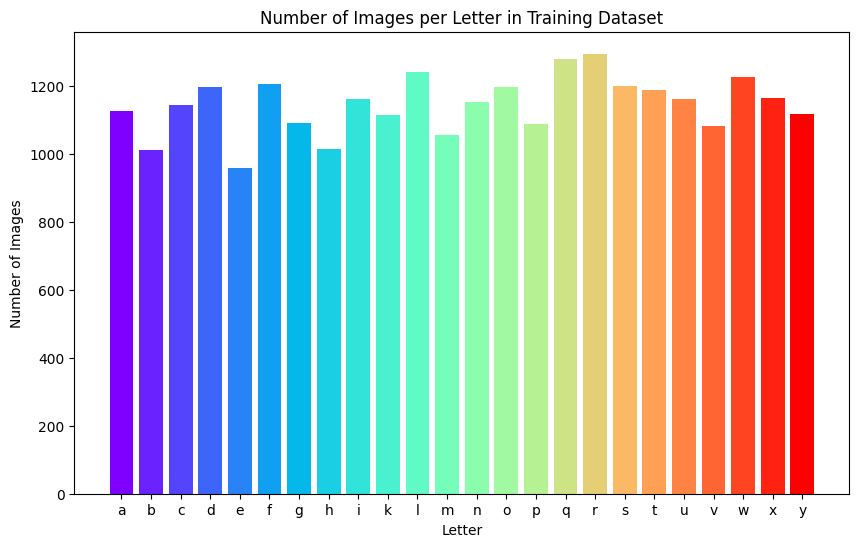

In [5]:
# Visualisation du nombre d'image par classe dans le jeu d'entraînement
letter_counts = {}
for label in y_train:
    letter = chr(label.item() + 97)  # Convertir le label en lettre (97 est le code ASCII pour 'a')
    if letter in letter_counts:
        letter_counts[letter] += 1
    else:
        letter_counts[letter] = 1

sorted_letters = sorted(letter_counts.keys())

# Créer l'histogramme
plt.figure(figsize=(10, 6))
colors = cm.rainbow(np.linspace(0, 1, len(sorted_letters)))
plt.bar(sorted_letters, [letter_counts[letter] for letter in sorted_letters], color=colors)
plt.xlabel('Letter')
plt.ylabel('Number of Images')
plt.title('Number of Images per Letter in Training Dataset')
plt.show()


In [6]:
history = {'train_loss': [], 'train_acc': [], 'test_loss': [], 'test_acc': []}

In [7]:
BATCH_SIZE = 32

torch_X_train = torch.from_numpy(X_train).type(torch.LongTensor)
torch_y_train = torch.from_numpy(y_train).type(torch.LongTensor)

torch_X_test = torch.from_numpy(X_test).type(torch.LongTensor)
torch_y_test = torch.from_numpy(y_test).type(torch.LongTensor)

In [8]:
def fit(model, train_loader):
    optimizer = torch.optim.Adam(model.parameters())
    loss_fn = nn.CrossEntropyLoss()
    epochs = 15
    model.train()
    for epoch in range(epochs):
        correct = 0
        for batch_id , (X_batch, y_batch) in enumerate(train_loader):
            var_X_batch = Variable(X_batch).float()
            var_y_batch = Variable(y_batch)
            optimizer.zero_grad()
            output = model(var_X_batch)
            loss = loss_fn(output, var_y_batch)
            loss.backward()
            optimizer.step()

            # Compte le nombre de prédictions correctes
            prediction = torch.max(output.data, 1)[1] 
            correct += (prediction == var_y_batch).sum()
            if batch_id % 50 == 0:
                print('Epoch : {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\t Accuracy:{:.3f}%'.format(
                    epoch, batch_id*len(X_batch), len(train_loader.dataset), 100.*batch_id / len(train_loader), loss.data, float(correct*100) / float(BATCH_SIZE*(batch_id+1))))
            # if float(correct*100) / float(BATCH_SIZE*(batch_id+1)) > 90:
            #     break

In [9]:
# Nous devons redimensionner les données pour les passer dans le réseau de neurones convolutif
torch_X_train = torch_X_train.view(-1, 1,28,28).float()
torch_X_test = torch_X_test.view(-1,1,28,28).float()

train = torch.utils.data.TensorDataset(torch_X_train,torch_y_train)
test = torch.utils.data.TensorDataset(torch_X_test,torch_y_test)

# charge les données dans le DataLoader de PyTorch
train_loader = torch.utils.data.DataLoader(train, batch_size = BATCH_SIZE, shuffle = True)
test_loader = torch.utils.data.DataLoader(test, batch_size = BATCH_SIZE, shuffle = False)

#### Augmentation des données

In [10]:
data_transforms = v2.Compose([
    v2.RandomRotation(degrees=10),
    #v2.RandomPerspective(distortion_scale=0.2),
    v2.RandomHorizontalFlip(p=0.5), 
    v2.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),  # Zoom et translation aléatoires
    #v2.ToDtype(torch.float32, scale=True),
    #v2.Normalize(mean=[0.485], std=[0.225])
])

In [12]:
percentage_of_augmented_data = 100 # 100 to double the amount of data
random_integers = random.sample(range(torch_X_train.size()[0]), int((percentage_of_augmented_data)/100*torch_X_train.size()[0]))


# Créer une liste pour stocker les nouveaux objets
new_images = []
new_labels = []

# Parcourir les indices aléatoires
for i in random_integers:
    img = torch_X_train[i]
    transformed_img = data_transforms(img)
    
    # Ajouter l'image transformée à la liste
    new_images.append(transformed_img.unsqueeze(0))
    
    # Ajouter l'étiquette correspondante à la liste
    new_labels.append(torch_y_train[i].unsqueeze(0))

print(torch_X_train.size())
# Concaténer les nouvelles images et étiquettes avec les données d'origine
if new_images:
    new_images = torch.cat(new_images, dim=0)
    new_labels = torch.cat(new_labels, dim=0)

    torch_X_train = torch.cat((torch_X_train, new_images), dim=0)
    torch_y_train = torch.cat((torch_y_train, new_labels), dim=0)

print(torch_X_train.size())

torch.Size([27455, 1, 28, 28])
torch.Size([54910, 1, 28, 28])


In [13]:
train = torch.utils.data.TensorDataset(torch_X_train,torch_y_train)
train_loader = torch.utils.data.DataLoader(train, batch_size = BATCH_SIZE, shuffle = True)

In [14]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 75, kernel_size=3, stride=1, padding=1)
        self.batchnorm1 = nn.BatchNorm2d(75)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        self.conv2 = nn.Conv2d(75, 50, kernel_size=3, stride=1, padding=1)
        self.dropout = nn.Dropout2d(p=0.2)
        self.batchnorm2 = nn.BatchNorm2d(50)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        self.conv3 = nn.Conv2d(50, 25, kernel_size=3, stride=1, padding=1)
        self.batchnorm3 = nn.BatchNorm2d(25)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        self.fc1 = nn.Linear(25*3*3, 512)
        self.dropout2 = nn.Dropout(p=0.3)
        self.fc2 = nn.Linear(512, 25)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.batchnorm1(x)
        x = self.pool1(x)
        
        x = F.relu(self.conv2(x))
        x = self.dropout(x)
        x = self.batchnorm2(x)
        x = self.pool2(x)
        
        x = F.relu(self.conv3(x))
        x = self.batchnorm3(x)
        x = self.pool3(x)
        
        x = x.view(-1, 25*3*3)
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

# Création de l'instance du modèle
cnn = ConvNet()
print(cnn)

ConvNet(
  (conv1): Conv2d(1, 75, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm1): BatchNorm2d(75, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(75, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dropout): Dropout2d(p=0.2, inplace=False)
  (batchnorm2): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(50, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm3): BatchNorm2d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=225, out_features=512, bias=True)
  (dropout2): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=512, out_features=25, bias=True)
)


In [33]:
fit(cnn,train_loader)

Epoch : 0 [0/54910 (0%)]	Loss: 0.278576	 Accuracy:96.875%
Epoch : 0 [1600/54910 (3%)]	Loss: 0.449219	 Accuracy:94.547%
Epoch : 0 [3200/54910 (6%)]	Loss: 0.165034	 Accuracy:94.369%
Epoch : 0 [4800/54910 (9%)]	Loss: 0.051961	 Accuracy:94.247%
Epoch : 0 [6400/54910 (12%)]	Loss: 0.113643	 Accuracy:94.310%
Epoch : 0 [8000/54910 (15%)]	Loss: 0.182249	 Accuracy:94.186%
Epoch : 0 [9600/54910 (17%)]	Loss: 0.201418	 Accuracy:94.207%
Epoch : 0 [11200/54910 (20%)]	Loss: 0.143130	 Accuracy:93.910%
Epoch : 0 [12800/54910 (23%)]	Loss: 0.073852	 Accuracy:93.976%
Epoch : 0 [14400/54910 (26%)]	Loss: 0.137779	 Accuracy:94.048%
Epoch : 0 [16000/54910 (29%)]	Loss: 0.423708	 Accuracy:94.112%
Epoch : 0 [17600/54910 (32%)]	Loss: 0.045413	 Accuracy:94.204%
Epoch : 0 [19200/54910 (35%)]	Loss: 0.164859	 Accuracy:94.187%
Epoch : 0 [20800/54910 (38%)]	Loss: 0.228473	 Accuracy:94.163%
Epoch : 0 [22400/54910 (41%)]	Loss: 0.107978	 Accuracy:94.218%
Epoch : 0 [24000/54910 (44%)]	Loss: 0.004440	 Accuracy:94.291%
Epoch 

In [34]:
def evaluate(model):
    correct = 0 
    for test_imgs, test_labels in test_loader:
        test_imgs = Variable(test_imgs).float()
        output = model(test_imgs)
        predicted = torch.max(output,1)[1]
        correct += (predicted == test_labels).sum()
    print("Test accuracy:{:.3f}% ".format( float(correct) / (len(test_loader)*BATCH_SIZE)))


In [38]:
evaluate(cnn)

Test accuracy:0.983% 


avec le modèle ConvNet et batch à 32 (sans data augmentation): test accuracy : 0.958%   
avec le modèle ConvNet et batch à 128 (sans data augmentation): test accuracy : 0.929%  
avec le modèle ConvNet et batch à 32 (avec data augmentation): test accuracy : 0.983%

Sauvons le modèle

In [37]:
#torch.save(cnn, "../save/m1.pth")

In [39]:
# Fonction pour afficher les poids des filtres
def visualize_conv_weights(weights, title):
    n_filters = weights.shape[0]
    n_channels = weights.shape[1]
    
    # Calcul de la disposition de la grille
    grid_size = int(np.ceil(np.sqrt(n_filters)))
    
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(grid_size*2, grid_size*2))
    fig.suptitle(title)
    
    for i, ax in enumerate(axes.flat):
        if i < n_filters:
            img = weights[i, 0].detach().numpy()
            img = (img - np.min(img)) / (np.max(img) - np.min(img))  # Normalisation
            ax.imshow(img, cmap='gray')
            ax.axis('off')
        else:
            ax.axis('off')  # Masquer les axes inutilisés
    plt.show()

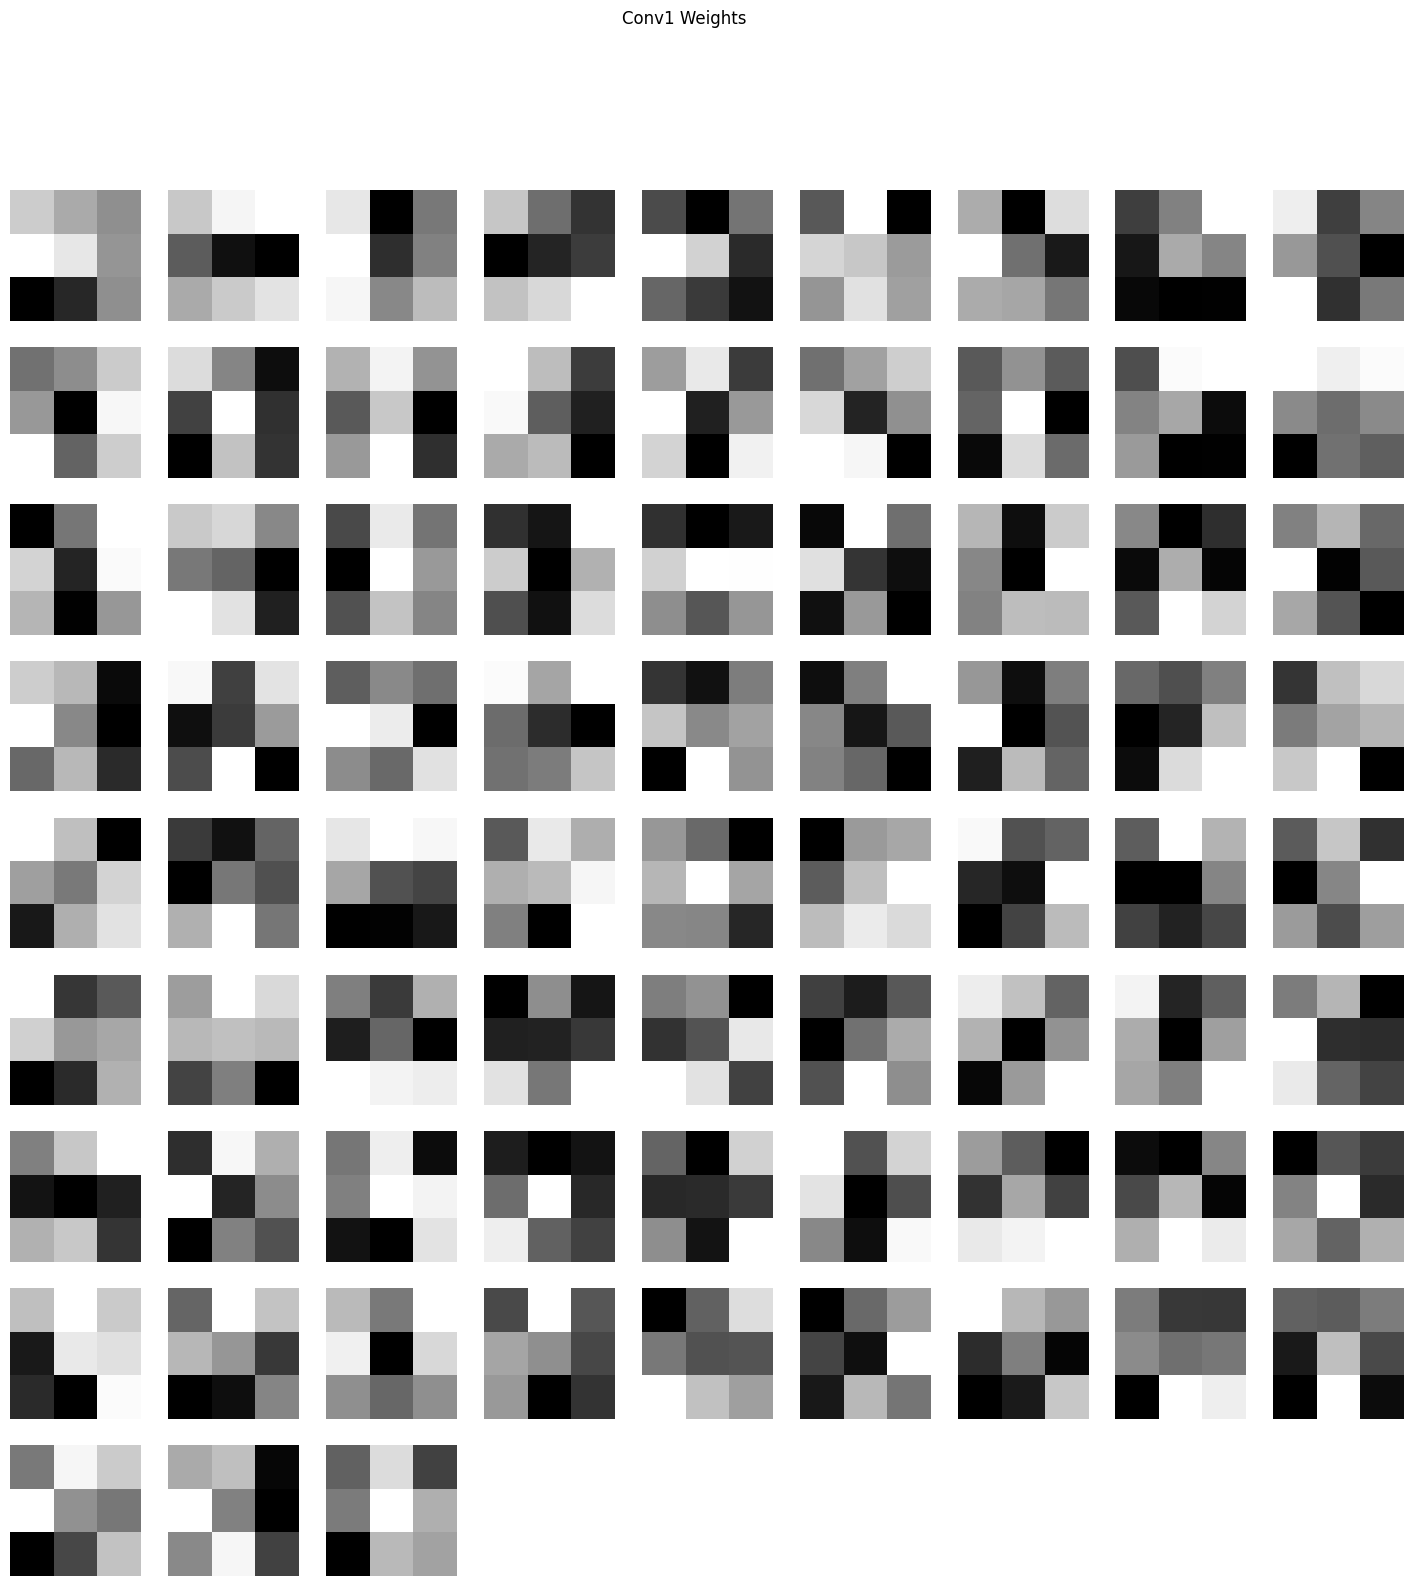

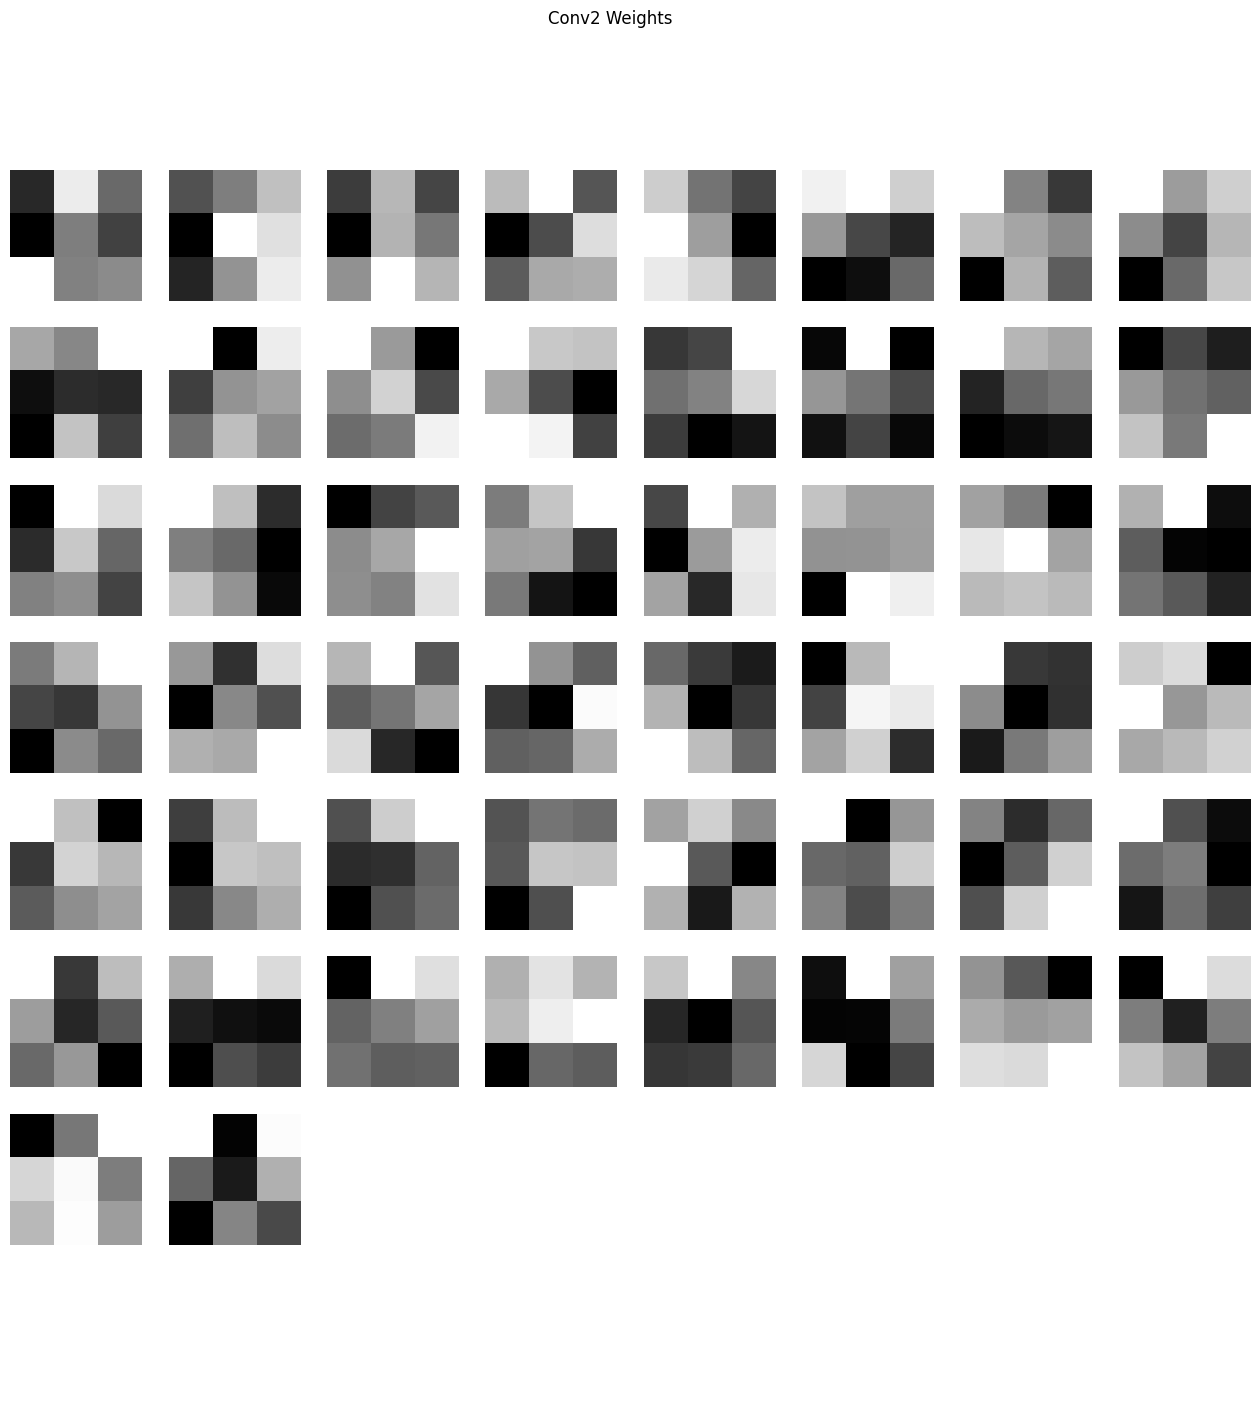

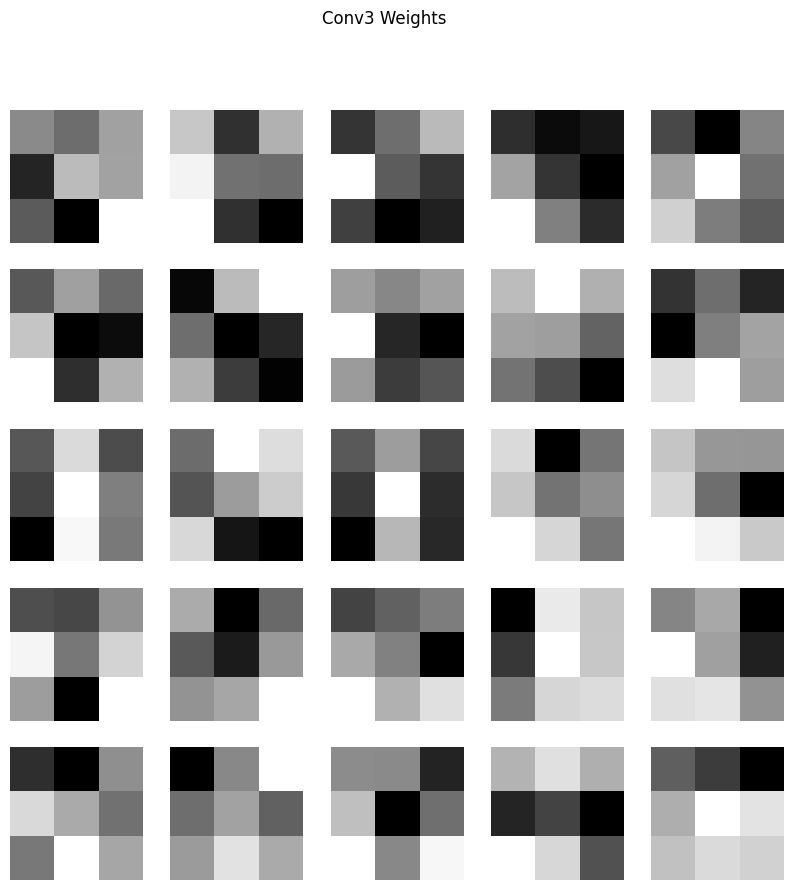

In [40]:
# Affichage des poids des filtres de la première couche de convolution
conv1_weights = cnn.conv1.weight
visualize_conv_weights(conv1_weights, "Conv1 Weights")
# Affichage des poids des filtres de la 2e couche de convolution
conv2_weights = cnn.conv2.weight
visualize_conv_weights(conv2_weights, "Conv2 Weights")
# Affichage des poids des filtres de la 3e couche de convolution
conv3_weights = cnn.conv3.weight
visualize_conv_weights(conv3_weights, "Conv3 Weights")

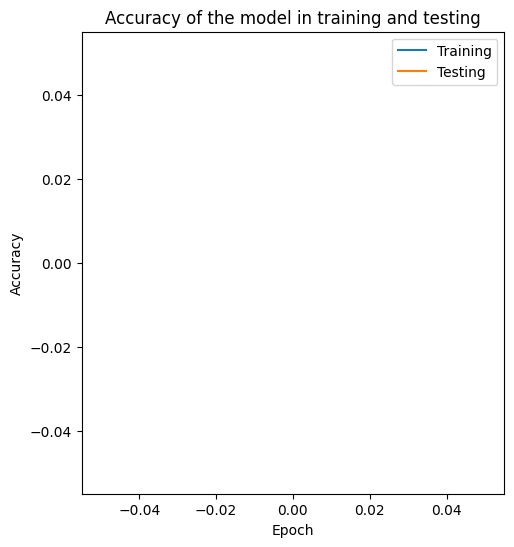

In [18]:
def plot_performance(history):
    epochs = len(history['train_loss'])
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, epochs+1), history['train_acc'], label='Training')
    plt.plot(range(1, epochs+1), history['test_acc'], label='Testing')
    plt.title('Accuracy of the model in training and testing')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

plot_performance(history)


[]


Test avec nos propres images

Predicted class: 11


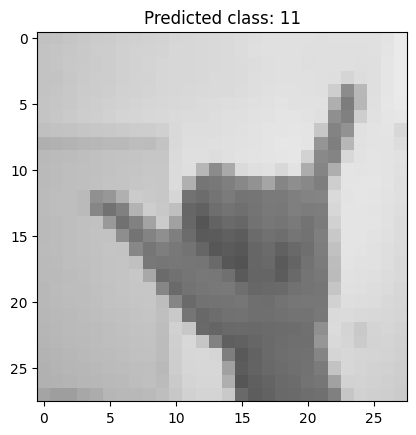

In [46]:
# Prétraitement de l'image
transform = v2.Compose([
    v2.Grayscale(num_output_channels=1),
    v2.Resize((28, 28)),
    v2.ToTensor(),
    v2.Normalize((0.5,), (0.5,))
])

def load_image(image_path):
    image = Image.open(image_path)
    image = transform(image)
    image = image.unsqueeze(0)  # Ajouter une dimension pour le batch
    return image

# Charger et prétraiter l'image de test
image_path = '../../data/ours/test.png'
image = load_image(image_path)

# Faire une prédiction
output = cnn(image)
_, predicted = torch.max(output, 1)

# Afficher le résultat
print(f'Predicted class: {predicted.item()}')

# Optionnel : afficher l'image
plt.imshow(Image.open(image_path), cmap='gray')
plt.title(f'Predicted class: {predicted.item()}')
plt.show()